In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset"

import os
print("📂 Current directory:", os.getcwd())
!apt install tree -y
!tree -L 2 -a --dirsfirst

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset
📂 Current directory: /content/drive/MyDrive/VAE, GAN & Diffusion Model on MNIST Dataset
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
.
├── data
│   └── MNIST
├── Model_from_Scratch
│   ├── __pycache__
│   ├── GAN.py
│   └── __init__.py
├── MVP_Model
└── Training_Model
    └── GAN_Train.ipynb

6 directories, 3 files


In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch, torch.nn as nn
import os
import sys

# I. Dataset Preparation

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# II. Model

## 1. Definition

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(nn.Linear(z_dim, 256),
                                    nn.LeakyReLU(0.2, inplace=False),
                                    nn.BatchNorm1d(256),
                                    nn.Linear(256, 512),
                                    nn.LeakyReLU(0.2, inplace=False),
                                    nn.BatchNorm1d(512),
                                    nn.Linear(512, 1024),
                                    nn.LeakyReLU(0.2, inplace=False),
                                    nn.BatchNorm1d(1024),
                                    nn.Linear(1024, 28 * 28),
                                    nn.Tanh()
                                    )
    def forward(self, z):
        # Input shape : [batch_size, z_dim]
        # Output shape: [batch_size, 28*28] -> reshape to [batch_size, 1, 28, 28]
        return self.model(z).view(z.size(0), 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Flatten(),
                                    nn.Linear(28 * 28, 1024),
                                    nn.LeakyReLU(0.2, inplace=False),
                                    nn.Dropout(0.3),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(0.2, inplace=False),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.LeakyReLU(0.2, inplace=False),
                                    nn.Dropout(0.3),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                )

    def forward(self, img):
        # Input shape : [batch_size, 1, 28, 28]
        # Output shape: [batch_size, 1]
        return self.model(img)

def train_GAN(epoch, gen, disc, dataloader, optimizer_G, optimizer_D, criterion, z_dim, device='cpu'):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0

    gen = gen.to(device)
    disc = disc.to(device)

    gen.train()
    disc.train()

    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(real_imgs.size(0), 1, device=device)

        z = torch.randn(real_imgs.size(0), z_dim, device=device)
        fake_imgs = gen(z)
        fake_labels = torch.zeros(fake_imgs.size(0), 1, device=device)


        # ----- Train Discriminator -----
        real_loss = criterion(disc(real_imgs), real_labels)
        optimizer_D.zero_grad()
        real_loss.backward()
        optimizer_D.step()

        fake_outputs = disc(fake_imgs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        optimizer_D.step()


        # ----- Train Generator -----
        optimizer_G.zero_grad()
        fake_outputs = disc(fake_imgs)
        fake_labels = torch.ones(real_imgs.size(0), 1, device=device)
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        optimizer_G.step()

        # ----- Log -----
        epoch_loss_G += (real_loss.item() + fake_loss.item()) * real_imgs.size(0)
        epoch_loss_D += gen_loss.item() * real_imgs.size(0)


    epoch_loss_D /= len(dataloader.dataset)
    epoch_loss_G /= len(dataloader.dataset)

    return epoch_loss_D, epoch_loss_G

## 2. Training

In [ ]:
root = os.path.abspath(".")
sys.path.append(root)
from Model_from_Scratch.GAN import Generator, Discriminator, train_GAN

In [ ]:
epoch = 30
gen = Generator(z_dim=100)
disc = Discriminator()
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
z_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = "./MVP_Model/GAN_mvp"
os.makedirs(save_dir, exist_ok=True)

Epoch [1/30] Completed | Avg Loss D: 1.4155 | Avg Loss G: 0.8557
Epoch [2/30] Completed | Avg Loss D: 1.2024 | Avg Loss G: 1.1012
Epoch [3/30] Completed | Avg Loss D: 0.9674 | Avg Loss G: 1.1715
Epoch [4/30] Completed | Avg Loss D: 0.8041 | Avg Loss G: 1.2601
Epoch [5/30] Completed | Avg Loss D: 0.7019 | Avg Loss G: 1.3227
Epoch [6/30] Completed | Avg Loss D: 0.6491 | Avg Loss G: 1.3610
Epoch [7/30] Completed | Avg Loss D: 0.6130 | Avg Loss G: 1.3815
Epoch [8/30] Completed | Avg Loss D: 0.5917 | Avg Loss G: 1.3952
Epoch [9/30] Completed | Avg Loss D: 0.5801 | Avg Loss G: 1.4024
Epoch [10/30] Completed | Avg Loss D: 0.5717 | Avg Loss G: 1.4059
Epoch [11/30] Completed | Avg Loss D: 0.5648 | Avg Loss G: 1.4077
Epoch [12/30] Completed | Avg Loss D: 0.5639 | Avg Loss G: 1.4082
Epoch [13/30] Completed | Avg Loss D: 0.5585 | Avg Loss G: 1.4117
Epoch [14/30] Completed | Avg Loss D: 0.5575 | Avg Loss G: 1.4104
Epoch [15/30] Completed | Avg Loss D: 0.5521 | Avg Loss G: 1.4146
Epoch [16/30] Compl

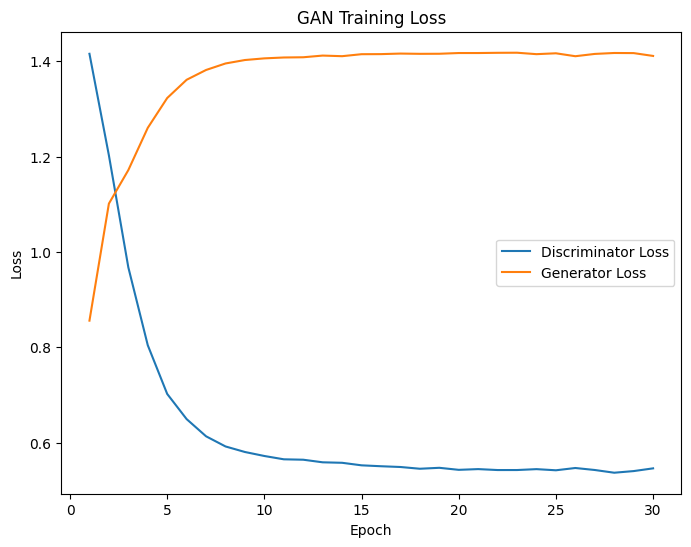

In [ ]:
loss_D_list, loss_G_list = [], []
best_loss_D = float('inf')

for i in range(epoch):
    epoch_loss_D, epoch_loss_G = train_GAN(epoch        = epoch,
                                            gen         = gen,
                                            disc        = disc,
                                            dataloader  = train_loader,
                                            optimizer_G = optimizer_G,
                                            optimizer_D = optimizer_D,
                                            criterion   = criterion,
                                            z_dim       = z_dim,
                                            device      = device,
                                            )
    loss_D_list.append(epoch_loss_D)
    loss_G_list.append(epoch_loss_G)

    print(f"Epoch [{i+1}/{epoch}] Completed | Avg Loss D: {epoch_loss_D:.4f} | Avg Loss G: {epoch_loss_G:.4f}")

    if epoch_loss_D < best_loss_D:
        best_loss_D = epoch_loss_D
        torch.save(gen.state_dict(), os.path.join(save_dir, "best_gen.pth"))
        torch.save(disc.state_dict(), os.path.join(save_dir, "best_disc.pth"))

# IV. Model testing

In [ ]:
save_dir = "./MVP_Model/GAN_mvp"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gen_test = Generator(z_dim=100)
gen_state = torch.load(os.path.join(save_dir, "best_gen.pth"), map_location=device)
gen_test.load_state_dict(gen_state)
gen_test.to(device)
gen_test.eval()

disc_test = Discriminator()
disc_state = torch.load(os.path.join(save_dir, "best_disc.pth"))
disc_test.load_state_dict(disc_state)
disc_test.to(device)
disc_test.eval();

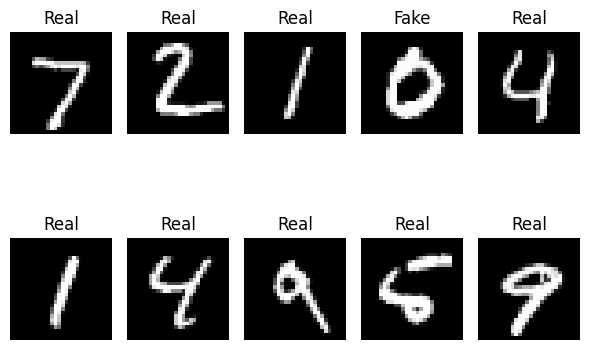

In [ ]:
images, labels = next(iter(test_loader))
images = images[:10].to(device)

with torch.no_grad():
    outputs = disc_test(images)
    predictions = (outputs > 0.5).cpu().numpy()  # >0.5 → real, else fake

fig, axes = plt.subplots(2, 5, figsize=(6, 5))
for i, ax in enumerate(axes.flat):  # flatten 2D array thành 1D
    img_to_show = (images[i].cpu().squeeze() * 0.5) + 0.5
    ax.imshow(img_to_show, cmap='gray')
    ax.set_title("Real" if predictions[i] else "Fake")
    ax.axis('off')

plt.tight_layout()
plt.show()

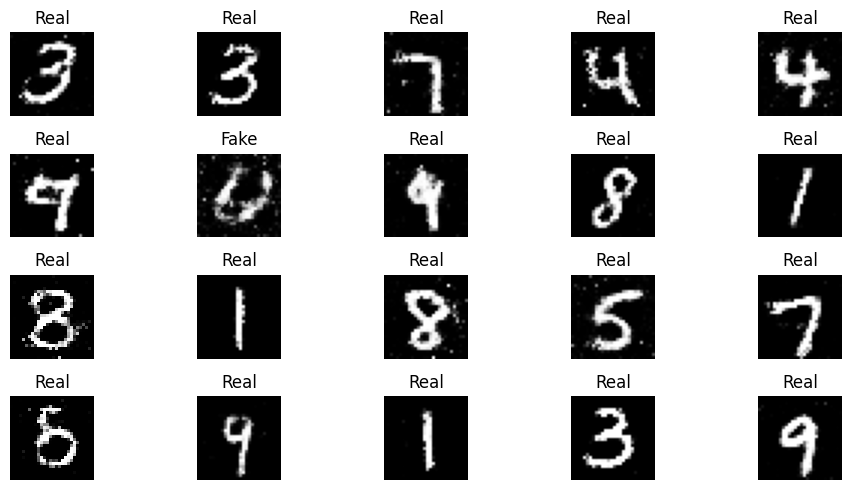

In [ ]:
num_samples = 20
latent_dim = 100

z = torch.randn(num_samples, latent_dim, device=device)

with torch.no_grad():
    generated_images = gen_test(z)
    outputs_gen = disc_test(generated_images)
    predictions_gen = (outputs_gen > 0.5).cpu().numpy()

fig, axes = plt.subplots(4, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img_to_show = (generated_images[i].cpu().squeeze() * 0.5) + 0.5  # scale [-1,1] -> [0,1]
    ax.imshow(img_to_show, cmap='gray')
    ax.set_title("Real" if predictions_gen[i] else "Fake")
    ax.axis('off')

plt.tight_layout()
plt.show()